In [1]:

# Para no tener que hacer restart con cada actualizacion 

%load_ext autoreload
%autoreload 2



# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.float_format = "{:,.2f}".format    #para la notación
pd.set_option("display.max_columns", None)
import pickle

from itertools import product, combinations

from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
import tqdm as tqdm
from scipy.stats import chi2_contingency
import os
import sys 
sys.path.append(os.path.abspath("../../src"))   
import Soporte_ajuste_modelos as f

# Para tratar el problema de desbalance
# -----------------------------------------------------------------------
# from imblearn.over_sampling import RandomOverSampler, SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.combine import SMOTETomek


from sklearn.model_selection import train_test_split,GridSearchCV
# Para realizar la clasificación y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve


from sklearn import tree

# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pickle

from sklearn.model_selection import KFold,LeaveOneOut, cross_val_score


from sklearn.preprocessing import StandardScaler

from tqdm import tqdm


# Ignorar los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')
import os 
import sys


#shap hace que no pueda usar el entorno del proyecto

pd.options.display.float_format = "{:,.2f}".format    #para la notación
pd.set_option("display.max_columns", None)

C:\Users\jaime\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_preprocesado=pd.read_pickle("../../datos/datos1/datos_out.pkl").reset_index(drop=True)

### Lo primero es tener claro que dentro de los errores que cometamos se priorice **minimizar** los **FALSOS NEGATIVOS (Predecimos que se quedan y en realidad se van)** por ello preferimos un ***Recall alto*** 

In [3]:
df_preprocesado.head()

,Age,Attrition,BusinessTravel,Department,EducationField,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,Gender_Female,Gender_Male,DistanceFromHome_entre 1 y 4,DistanceFromHome_entre 13 y 18,DistanceFromHome_entre 19 y 23,DistanceFromHome_entre 24 y 29,DistanceFromHome_entre 5 y 8,DistanceFromHome_entre 9 y 12,Education_Bachelor,Education_Below College,Education_College,Education_Doctor,Education_Master,JobLevel_Head,JobLevel_Intern,JobLevel_Junior,JobLevel_Manager,JobLevel_Senior,StockOptionLevel_Bad,StockOptionLevel_Best,StockOptionLevel_Better,StockOptionLevel_Good
0,1.15,0.00,0.00,-1.00,0.53,-0.46,0.00,1.50,0.00,-0.50,4.57,-3.42,-0.67,-0.33,0.00,-0.98,1.00,0.00,1.00,-1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
1,-0.38,1.00,0.10,0.00,0.53,0.52,1.00,-0.13,-1.00,1.50,0.51,0.10,0.00,0.00,0.00,0.02,1.45,1.00,1.00,-1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2,-0.31,0.00,0.10,0.00,-4.21,0.18,0.00,2.63,0.00,0.17,0.58,0.00,0.00,-0.33,0.79,0.02,6.90,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
3,0.15,0.00,-0.07,0.00,0.53,-0.75,0.00,0.62,-1.22,-0.50,-0.59,-0.90,0.50,2.00,-0.21,-0.98,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
4,-0.31,0.00,0.00,0.00,0.00,0.18,1.00,-0.47,-0.93,-0.33,-0.42,0.00,0.17,-0.33,-0.21,1.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


## LOG REG

In [4]:
# logistic_regression = {
#     'penalty': ['l1', 'l2', 'elasticnet', 'none'],
#     'C': [0.005, 0.01,0.05, 0.1, 1, 10, 100],
#     'solver': ['liblinear', 'saga'],
#     'max_iter': [10,20,40,100,150]
# }

In [5]:
modelos_clasificacion=f.AnalisisModelosClasificacion(df_preprocesado, "Attrition",train_size=0.8)
modelos_clasificacion.ajustar_modelo("logistic_regression", param_grid=None, cross_validation = 5,scoring="accuracy", ruta_guardar_modelo = "../../transformers",nombre_modelo_guardar="modelo_log1.pkl")

-------------------------------------------------
El mejor modelo es:
LogisticRegression(C=0.1, random_state=42, solver='liblinear')
-------------------------------------------------
Los parametros actuales son:


{'penalty': ['l1', 'l2', 'elasticnet', 'none'],
 'C': [0.01, 0.1, 1, 10, 100],
 'solver': ['liblinear', 'saga'],
 'max_iter': [100, 200, 500]}

In [6]:
modelos_clasificacion.calcular_metricas(modelo_nombre="logistic_regression").T

,accuracy,precision,recall,f1,kappa,auc
train,0.86,0.84,0.86,0.83,0.32,0.81
test,0.85,0.82,0.85,0.82,0.23,0.75


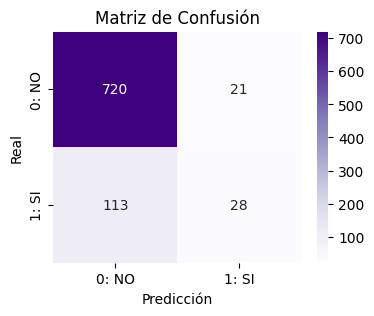

In [7]:
modelos_clasificacion.plot_matriz_confusion("logistic_regression", invertir=False, tamano_grafica=(4, 3), labels=True, label0="NO", label1="SI")

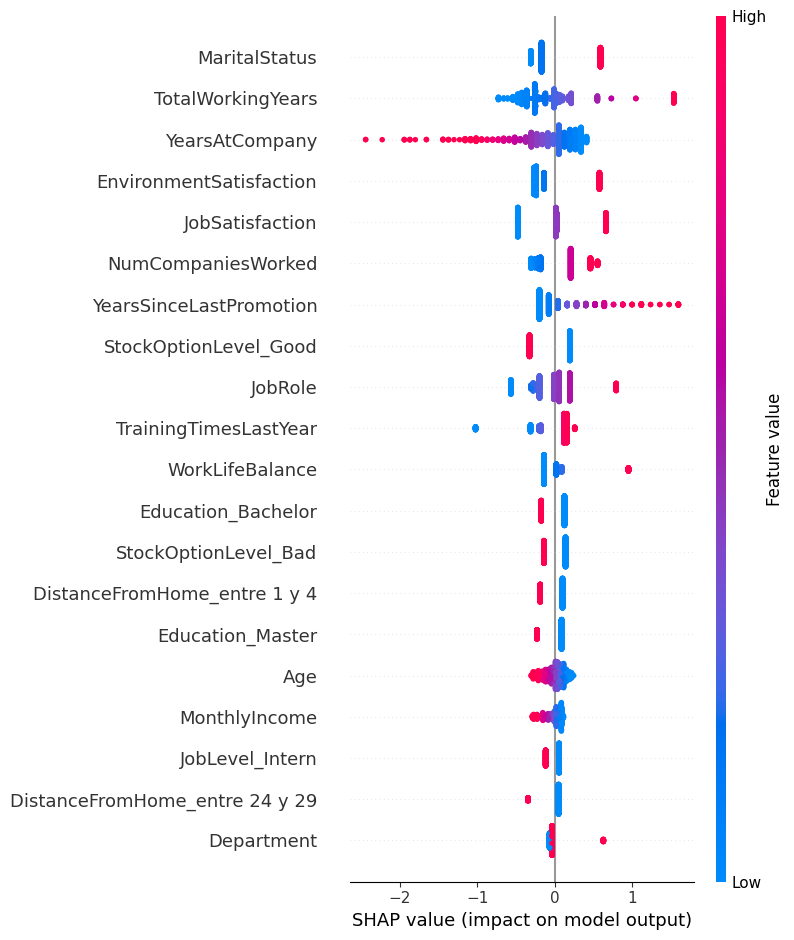

In [8]:
modelos_clasificacion.plot_shap_summary("logistic_regression")

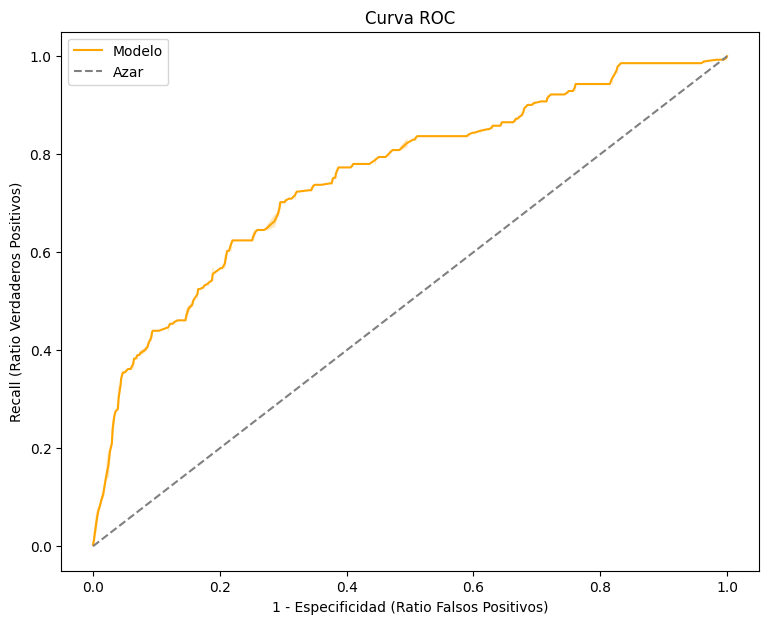

In [9]:
modelos_clasificacion.plot_curva_ROC( grafica_size = (9,7))

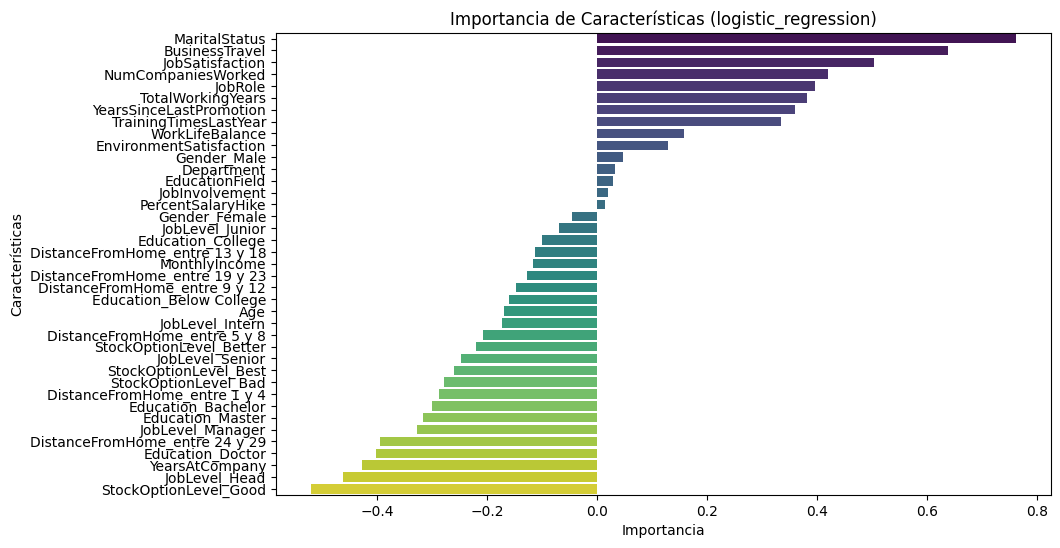

In [10]:
modelos_clasificacion.importancia_predictores("logistic_regression")